<a href="https://colab.research.google.com/github/denisakatov/Data-analysis-on-Kaggle/blob/main/hm7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В работе

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import gmean, rankdata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold

In [2]:
applications_history = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Kaggle /7/applications_history.csv')
bki = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Kaggle /7/bki.csv')
client_profile = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Kaggle /7/client_profile.csv')
payments = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Kaggle /7/payments.csv')
sample_submit = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Kaggle /7/sample_submit.csv')


In [3]:
data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Kaggle /7/train.csv")

test = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Kaggle /7/test.csv")
print("data.shape = {} rows, {} cols".format(*data.shape))

data.shape = 110093 rows, 3 cols


In [4]:
train = pd.concat([data, test], axis=0).reset_index(drop=True)
# train = pd.get_dummies(train, columns=categorical)

# data_ohe = train.loc[:data.shape[0]-1]
# test_ohe = train.loc[data.shape[0]:]

In [5]:
data = data.merge(client_profile, on='APPLICATION_NUMBER', how='left')

In [6]:
categorical = data.dtypes[data.dtypes == "object"].index
numerical = list(set(data.columns) - set(categorical))
data[numerical] = data[numerical].astype(float)
data[categorical] = data[categorical].astype('category')

In [7]:
data.head(1)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442.0,0.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0


In [8]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=5000,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

In [9]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

cv = KFold(n_splits=7, random_state=435, shuffle=True)
target, data = data["TARGET"], data.drop(["TARGET"], axis=1)

## BaseModel

In [10]:
for i in categorical:
  data[i] = data[i].astype('category')

In [11]:
estimators, oof_preds = lightgbm_cross_validation(
    lgbm_params, data, target, cv
)

Sat Apr 17 07:42:40 2021, Cross-Validation, 110093 rows, 25 cols
Training until validation scores don't improve for 5000 rounds.
[50]	valid_0's binary_logloss: 0.273474	valid_0's auc: 0.728858
[100]	valid_0's binary_logloss: 0.26848	valid_0's auc: 0.729502
[150]	valid_0's binary_logloss: 0.264825	valid_0's auc: 0.73049
[200]	valid_0's binary_logloss: 0.261872	valid_0's auc: 0.730735
[250]	valid_0's binary_logloss: 0.259636	valid_0's auc: 0.731
[300]	valid_0's binary_logloss: 0.257932	valid_0's auc: 0.731701
[350]	valid_0's binary_logloss: 0.256646	valid_0's auc: 0.732072
[400]	valid_0's binary_logloss: 0.255612	valid_0's auc: 0.732674
[450]	valid_0's binary_logloss: 0.254797	valid_0's auc: 0.733158
[500]	valid_0's binary_logloss: 0.254145	valid_0's auc: 0.733602
[550]	valid_0's binary_logloss: 0.253569	valid_0's auc: 0.73344
[600]	valid_0's binary_logloss: 0.253133	valid_0's auc: 0.73333
[650]	valid_0's binary_logloss: 0.252822	valid_0's auc: 0.73349
[700]	valid_0's binary_logloss: 0.2

In [12]:
score = roc_auc_score(target, oof_preds)
print(f"Score = {round(score, 4)}")

Score = 0.7188


## BaseModel + OneHotEncoding

In [13]:
categorical = [col for col in data.columns if col.endswith("_cat")]

train = pd.concat([data, test], axis=0).reset_index(drop=True)
train = pd.get_dummies(train, columns=categorical)

data_ohe = train.loc[:data.shape[0]-1]
test_ohe = train.loc[data.shape[0]:]

In [14]:
data_ohe

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442.0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683.0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0
3,123710391.0,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,0.031329,22338.0,365243.0,NaN,0.0,0.0,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0
4,123590329.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110089,123672463.0,Cash,F,0.0,175500.0,269550.0,12618.0,Secondary / secondary special,Married,0.010032,10519.0,1354.0,NaN,0.0,0.0,2.0,0.528096,0.471774,0.581484,0.0,0.0,0.0,0.0,0.0,2.0
110090,123723001.0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110091,123554358.0,Cash,F,2.0,270000.0,1024740.0,49428.0,Incomplete higher,Married,0.019101,15008.0,361.0,22.0,0.0,0.0,4.0,0.653826,0.651227,0.558507,0.0,0.0,0.0,1.0,0.0,1.0


In [15]:
numerical = data.select_dtypes(include=[np.number]).index


categorical = list(set(data.columns) - set(numerical))


In [94]:
categorical


Index(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], dtype='object')

In [17]:
for i in categorical:
  data_ohe[i] = data_ohe[i].astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
estimators_with_ohe, oof_preds_with_ohe = lightgbm_cross_validation(
    lgbm_params, data_ohe, target, cv
)

Sat Apr 17 07:44:29 2021, Cross-Validation, 110093 rows, 25 cols
Training until validation scores don't improve for 5000 rounds.
[50]	valid_0's binary_logloss: 0.27738	valid_0's auc: 0.653281
[100]	valid_0's binary_logloss: 0.274854	valid_0's auc: 0.658117
[150]	valid_0's binary_logloss: 0.272924	valid_0's auc: 0.660676
[200]	valid_0's binary_logloss: 0.271658	valid_0's auc: 0.660758
[250]	valid_0's binary_logloss: 0.270529	valid_0's auc: 0.661457
[300]	valid_0's binary_logloss: 0.269767	valid_0's auc: 0.661158
[350]	valid_0's binary_logloss: 0.269052	valid_0's auc: 0.661796
[400]	valid_0's binary_logloss: 0.268539	valid_0's auc: 0.662243
[450]	valid_0's binary_logloss: 0.268166	valid_0's auc: 0.66306
[500]	valid_0's binary_logloss: 0.267827	valid_0's auc: 0.663631
[550]	valid_0's binary_logloss: 0.267599	valid_0's auc: 0.664157
[600]	valid_0's binary_logloss: 0.26741	valid_0's auc: 0.66417
[650]	valid_0's binary_logloss: 0.26734	valid_0's auc: 0.663857
[700]	valid_0's binary_logloss: 

In [19]:
score = roc_auc_score(target, oof_preds_with_ohe)
print(f"Score = {round(score, 4)}")

Score = 0.6577


## BaseModel + LightGBM-encoder

In [20]:
estimators_cat, oof_preds_cat = lightgbm_cross_validation(
    lgbm_params, data, target, cv, categorical=categorical
)

Sat Apr 17 07:46:40 2021, Cross-Validation, 110093 rows, 25 cols


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE', 'AMOUNT_ANNUITY', 'AMOUNT_CREDIT', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'APPLICATION_NUMBER', 'CHILDRENS', 'DAYS_ON_LAST_JOB', 'EDUCATION_LEVEL', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3', 'FAMILY_SIZE', 'FAMILY_STATUS', 'FLAG_EMAIL', 'FLAG_PHONE', 'GENDER', 'NAME_CONTRACT_TYPE', 'OWN_CAR_AGE', 'REGION_POPULATION', 'TOTAL_SALARY']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds.
[50]	valid_0's binary_logloss: 0.278138	valid_0's auc: 0.629897
[100]	valid_0's binary_logloss: 0.276228	valid_0's auc: 0.632623
[150]	valid_0's binary_logloss: 0.274986	valid_0's auc: 0.632946
[200]	valid_0's binary_logloss: 0.274168	valid_0's auc: 0.631175
[250]	valid_0's binary_logloss: 0.273535	valid_0's auc: 0.629648
[300]	valid_0's binary_logloss: 0.273202	valid_0's auc: 0.629284
[350]	valid_0's binary_logloss: 0.272968	valid_0's auc: 0.628199
[400]	valid_0's binary_logloss: 0.272777	valid_0's auc: 0.628493
[450]	valid_0's binary_logloss: 0.272645	valid_0's auc: 0.629441
[500]	valid_0's binary_logloss: 0.272637	valid_0's auc: 0.628895
[550]	valid_0's binary_logloss: 0.272564	valid_0's auc: 0.628707
[600]	valid_0's binary_logloss: 0.272532	valid_0's auc: 0.628914
[650]	valid_0's binary_logloss: 0.272625	valid_0's auc: 0.628064
[700]	valid_0's binary_logloss: 0.27267	valid_0's auc: 0.627674
[750]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE', 'AMOUNT_ANNUITY', 'AMOUNT_CREDIT', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'APPLICATION_NUMBER', 'CHILDRENS', 'DAYS_ON_LAST_JOB', 'EDUCATION_LEVEL', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3', 'FAMILY_SIZE', 'FAMILY_STATUS', 'FLAG_EMAIL', 'FLAG_PHONE', 'GENDER', 'NAME_CONTRACT_TYPE', 'OWN_CAR_AGE', 'REGION_POPULATION', 'TOTAL_SALARY']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds.
[50]	valid_0's binary_logloss: 0.27951	valid_0's auc: 0.621066
[100]	valid_0's binary_logloss: 0.277775	valid_0's auc: 0.623543
[150]	valid_0's binary_logloss: 0.276689	valid_0's auc: 0.623869
[200]	valid_0's binary_logloss: 0.27601	valid_0's auc: 0.623029
[250]	valid_0's binary_logloss: 0.275555	valid_0's auc: 0.622964
[300]	valid_0's binary_logloss: 0.275404	valid_0's auc: 0.621611
[350]	valid_0's binary_logloss: 0.275276	valid_0's auc: 0.621917
[400]	valid_0's binary_logloss: 0.275242	valid_0's auc: 0.621914
[450]	valid_0's binary_logloss: 0.275254	valid_0's auc: 0.622665
[500]	valid_0's binary_logloss: 0.27539	valid_0's auc: 0.622788
[550]	valid_0's binary_logloss: 0.27551	valid_0's auc: 0.622939
[600]	valid_0's binary_logloss: 0.275646	valid_0's auc: 0.623149
[650]	valid_0's binary_logloss: 0.275813	valid_0's auc: 0.622802
[700]	valid_0's binary_logloss: 0.276052	valid_0's auc: 0.622271
[750]	valid_0's binary_logloss:

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE', 'AMOUNT_ANNUITY', 'AMOUNT_CREDIT', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'APPLICATION_NUMBER', 'CHILDRENS', 'DAYS_ON_LAST_JOB', 'EDUCATION_LEVEL', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3', 'FAMILY_SIZE', 'FAMILY_STATUS', 'FLAG_EMAIL', 'FLAG_PHONE', 'GENDER', 'NAME_CONTRACT_TYPE', 'OWN_CAR_AGE', 'REGION_POPULATION', 'TOTAL_SALARY']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds.
[50]	valid_0's binary_logloss: 0.283286	valid_0's auc: 0.632165
[100]	valid_0's binary_logloss: 0.281198	valid_0's auc: 0.634094
[150]	valid_0's binary_logloss: 0.279806	valid_0's auc: 0.634246
[200]	valid_0's binary_logloss: 0.278861	valid_0's auc: 0.635164
[250]	valid_0's binary_logloss: 0.27818	valid_0's auc: 0.634839
[300]	valid_0's binary_logloss: 0.277853	valid_0's auc: 0.634301
[350]	valid_0's binary_logloss: 0.277622	valid_0's auc: 0.633121
[400]	valid_0's binary_logloss: 0.277439	valid_0's auc: 0.633419
[450]	valid_0's binary_logloss: 0.277357	valid_0's auc: 0.632777
[500]	valid_0's binary_logloss: 0.277354	valid_0's auc: 0.633003
[550]	valid_0's binary_logloss: 0.277384	valid_0's auc: 0.632948
[600]	valid_0's binary_logloss: 0.27743	valid_0's auc: 0.633028
[650]	valid_0's binary_logloss: 0.277559	valid_0's auc: 0.632743
[700]	valid_0's binary_logloss: 0.277682	valid_0's auc: 0.631463
[750]	valid_0's binary_loglos

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE', 'AMOUNT_ANNUITY', 'AMOUNT_CREDIT', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'APPLICATION_NUMBER', 'CHILDRENS', 'DAYS_ON_LAST_JOB', 'EDUCATION_LEVEL', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3', 'FAMILY_SIZE', 'FAMILY_STATUS', 'FLAG_EMAIL', 'FLAG_PHONE', 'GENDER', 'NAME_CONTRACT_TYPE', 'OWN_CAR_AGE', 'REGION_POPULATION', 'TOTAL_SALARY']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds.
[50]	valid_0's binary_logloss: 0.276246	valid_0's auc: 0.61834
[100]	valid_0's binary_logloss: 0.274604	valid_0's auc: 0.619301
[150]	valid_0's binary_logloss: 0.273467	valid_0's auc: 0.620152
[200]	valid_0's binary_logloss: 0.272802	valid_0's auc: 0.620509
[250]	valid_0's binary_logloss: 0.27237	valid_0's auc: 0.621524
[300]	valid_0's binary_logloss: 0.272141	valid_0's auc: 0.620931
[350]	valid_0's binary_logloss: 0.272009	valid_0's auc: 0.6206
[400]	valid_0's binary_logloss: 0.271976	valid_0's auc: 0.620589
[450]	valid_0's binary_logloss: 0.271979	valid_0's auc: 0.620588
[500]	valid_0's binary_logloss: 0.27209	valid_0's auc: 0.620558
[550]	valid_0's binary_logloss: 0.272173	valid_0's auc: 0.619922
[600]	valid_0's binary_logloss: 0.272282	valid_0's auc: 0.620082
[650]	valid_0's binary_logloss: 0.272434	valid_0's auc: 0.619763
[700]	valid_0's binary_logloss: 0.272609	valid_0's auc: 0.619495
[750]	valid_0's binary_logloss: 

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE', 'AMOUNT_ANNUITY', 'AMOUNT_CREDIT', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'APPLICATION_NUMBER', 'CHILDRENS', 'DAYS_ON_LAST_JOB', 'EDUCATION_LEVEL', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3', 'FAMILY_SIZE', 'FAMILY_STATUS', 'FLAG_EMAIL', 'FLAG_PHONE', 'GENDER', 'NAME_CONTRACT_TYPE', 'OWN_CAR_AGE', 'REGION_POPULATION', 'TOTAL_SALARY']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds.
[50]	valid_0's binary_logloss: 0.279197	valid_0's auc: 0.637002
[100]	valid_0's binary_logloss: 0.277275	valid_0's auc: 0.639679
[150]	valid_0's binary_logloss: 0.275939	valid_0's auc: 0.63997
[200]	valid_0's binary_logloss: 0.275041	valid_0's auc: 0.640765
[250]	valid_0's binary_logloss: 0.274339	valid_0's auc: 0.641166
[300]	valid_0's binary_logloss: 0.27394	valid_0's auc: 0.641813
[350]	valid_0's binary_logloss: 0.273576	valid_0's auc: 0.642903
[400]	valid_0's binary_logloss: 0.273306	valid_0's auc: 0.643522
[450]	valid_0's binary_logloss: 0.273123	valid_0's auc: 0.643318
[500]	valid_0's binary_logloss: 0.273022	valid_0's auc: 0.643265
[550]	valid_0's binary_logloss: 0.272911	valid_0's auc: 0.643621
[600]	valid_0's binary_logloss: 0.272858	valid_0's auc: 0.643263
[650]	valid_0's binary_logloss: 0.272874	valid_0's auc: 0.642922
[700]	valid_0's binary_logloss: 0.272957	valid_0's auc: 0.641828
[750]	valid_0's binary_loglos

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE', 'AMOUNT_ANNUITY', 'AMOUNT_CREDIT', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'APPLICATION_NUMBER', 'CHILDRENS', 'DAYS_ON_LAST_JOB', 'EDUCATION_LEVEL', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3', 'FAMILY_SIZE', 'FAMILY_STATUS', 'FLAG_EMAIL', 'FLAG_PHONE', 'GENDER', 'NAME_CONTRACT_TYPE', 'OWN_CAR_AGE', 'REGION_POPULATION', 'TOTAL_SALARY']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds.
[50]	valid_0's binary_logloss: 0.27932	valid_0's auc: 0.618403
[100]	valid_0's binary_logloss: 0.27753	valid_0's auc: 0.621779
[150]	valid_0's binary_logloss: 0.276363	valid_0's auc: 0.623029
[200]	valid_0's binary_logloss: 0.275648	valid_0's auc: 0.623708
[250]	valid_0's binary_logloss: 0.275119	valid_0's auc: 0.62321
[300]	valid_0's binary_logloss: 0.274893	valid_0's auc: 0.622829
[350]	valid_0's binary_logloss: 0.274733	valid_0's auc: 0.623208
[400]	valid_0's binary_logloss: 0.274668	valid_0's auc: 0.623591
[450]	valid_0's binary_logloss: 0.274682	valid_0's auc: 0.623686
[500]	valid_0's binary_logloss: 0.274753	valid_0's auc: 0.623733
[550]	valid_0's binary_logloss: 0.274802	valid_0's auc: 0.624119
[600]	valid_0's binary_logloss: 0.274921	valid_0's auc: 0.623735
[650]	valid_0's binary_logloss: 0.275086	valid_0's auc: 0.624189
[700]	valid_0's binary_logloss: 0.275245	valid_0's auc: 0.623978
[750]	valid_0's binary_logloss

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE', 'AMOUNT_ANNUITY', 'AMOUNT_CREDIT', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'APPLICATION_NUMBER', 'CHILDRENS', 'DAYS_ON_LAST_JOB', 'EDUCATION_LEVEL', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3', 'FAMILY_SIZE', 'FAMILY_STATUS', 'FLAG_EMAIL', 'FLAG_PHONE', 'GENDER', 'NAME_CONTRACT_TYPE', 'OWN_CAR_AGE', 'REGION_POPULATION', 'TOTAL_SALARY']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5000 rounds.
[50]	valid_0's binary_logloss: 0.270842	valid_0's auc: 0.619009
[100]	valid_0's binary_logloss: 0.269223	valid_0's auc: 0.62464
[150]	valid_0's binary_logloss: 0.268159	valid_0's auc: 0.623599
[200]	valid_0's binary_logloss: 0.267518	valid_0's auc: 0.623124
[250]	valid_0's binary_logloss: 0.267002	valid_0's auc: 0.62396
[300]	valid_0's binary_logloss: 0.26672	valid_0's auc: 0.623453
[350]	valid_0's binary_logloss: 0.26652	valid_0's auc: 0.624483
[400]	valid_0's binary_logloss: 0.266345	valid_0's auc: 0.62474
[450]	valid_0's binary_logloss: 0.266256	valid_0's auc: 0.626122
[500]	valid_0's binary_logloss: 0.266231	valid_0's auc: 0.626161
[550]	valid_0's binary_logloss: 0.266167	valid_0's auc: 0.626774
[600]	valid_0's binary_logloss: 0.266165	valid_0's auc: 0.627292
[650]	valid_0's binary_logloss: 0.266205	valid_0's auc: 0.62722
[700]	valid_0's binary_logloss: 0.266288	valid_0's auc: 0.626649
[750]	valid_0's binary_logloss: 0

In [21]:
score = roc_auc_score(target, oof_preds_cat)
print(f"Score = {round(score, 4)}")

Score = 0.628


## LightGBM with different hyperparams

In [26]:
params = {
    'boosting_type': 'goss',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

In [27]:
estimators_goss, oof_preds_goss = lightgbm_cross_validation(
    params, data, target, cv
)

Sat Apr 17 07:51:28 2021, Cross-Validation, 110093 rows, 25 cols
Training until validation scores don't improve for 5000 rounds.
[50]	valid_0's binary_logloss: 0.273474	valid_0's auc: 0.728858
[100]	valid_0's binary_logloss: 0.26848	valid_0's auc: 0.729502
[150]	valid_0's binary_logloss: 0.264825	valid_0's auc: 0.73049
[200]	valid_0's binary_logloss: 0.261856	valid_0's auc: 0.730846
[250]	valid_0's binary_logloss: 0.25963	valid_0's auc: 0.732543
[300]	valid_0's binary_logloss: 0.257897	valid_0's auc: 0.732944
[350]	valid_0's binary_logloss: 0.256642	valid_0's auc: 0.732493
[400]	valid_0's binary_logloss: 0.255611	valid_0's auc: 0.733199
[450]	valid_0's binary_logloss: 0.254809	valid_0's auc: 0.733344
[500]	valid_0's binary_logloss: 0.254147	valid_0's auc: 0.733526
[550]	valid_0's binary_logloss: 0.25359	valid_0's auc: 0.733598
[600]	valid_0's binary_logloss: 0.253194	valid_0's auc: 0.733397
[650]	valid_0's binary_logloss: 0.252862	valid_0's auc: 0.733407
[700]	valid_0's binary_logloss:

In [28]:
score = roc_auc_score(target, oof_preds_goss)
print(f"Score = {round(score, 4)}")

Score = 0.7193


## XGBoost

In [29]:
categorical_columns =['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS']

for i in categorical_columns:
  data[i] = data[i].astype('category')

In [30]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 42
}

xgb_cv = KFold(n_splits=10, random_state=42, shuffle=True)

In [31]:
print(data.dtypes)


APPLICATION_NUMBER             float64
NAME_CONTRACT_TYPE            category
GENDER                        category
CHILDRENS                      float64
TOTAL_SALARY                   float64
AMOUNT_CREDIT                  float64
AMOUNT_ANNUITY                 float64
EDUCATION_LEVEL               category
FAMILY_STATUS                 category
REGION_POPULATION              float64
AGE                            float64
DAYS_ON_LAST_JOB               float64
OWN_CAR_AGE                    float64
FLAG_PHONE                     float64
FLAG_EMAIL                     float64
FAMILY_SIZE                    float64
EXTERNAL_SCORING_RATING_1      float64
EXTERNAL_SCORING_RATING_2      float64
EXTERNAL_SCORING_RATING_3      float64
AMT_REQ_CREDIT_BUREAU_HOUR     float64
AMT_REQ_CREDIT_BUREAU_DAY      float64
AMT_REQ_CREDIT_BUREAU_WEEK     float64
AMT_REQ_CREDIT_BUREAU_MON      float64
AMT_REQ_CREDIT_BUREAU_QRT      float64
AMT_REQ_CREDIT_BUREAU_YEAR     float64
dtype: object


In [32]:
xgb_estimators, _, xgb_oof = xgboost_cross_validation(
    xgb_params, data.drop(categorical_columns, axis = 1), target, xgb_cv
)

Sat Apr 17 07:53:34 2021, Cross-Validation, 110093 rows, 21 cols
[0]	train-auc:0.658502	valid-auc:0.667291
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.705295	valid-auc:0.713656
[20]	train-auc:0.711695	valid-auc:0.719588
[30]	train-auc:0.713982	valid-auc:0.721573
[40]	train-auc:0.715253	valid-auc:0.723626
[50]	train-auc:0.717361	valid-auc:0.724666
[60]	train-auc:0.718581	valid-auc:0.726457
[70]	train-auc:0.719584	valid-auc:0.727851
[80]	train-auc:0.721528	valid-auc:0.728879
[90]	train-auc:0.723135	valid-auc:0.729914
[100]	train-auc:0.724538	valid-auc:0.729707
[110]	train-auc:0.725733	valid-auc:0.730104
[120]	train-auc:0.726526	valid-auc:0.73027
[130]	train-auc:0.727348	valid-auc:0.729915
Stopping. Best iteration:
[112]	train-auc:0.725812	valid-auc:0.730712

Fold 1, Valid score = 0.73012
[0]	train-auc:0.65799	valid-auc:0.667128
Multiple eval metrics have been passed: 'valid

In [33]:
score = roc_auc_score(target, xgb_oof)
print(f"Score = {round(score, 4)}")

Score = 0.6996


## Матрица корреляции

In [103]:
scores = pd.DataFrame({
    "lgbm_numerical": oof_preds,
    "lgbm_categorical": oof_preds_cat,
    "lgbm_with_ohe": oof_preds_with_ohe,
    # "lgbm_numerical_with_permutation": oof_preds_perm,
    "lgbm_goss_numerical": oof_preds_goss,
    "xgb_numerical": xgb_oof,
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

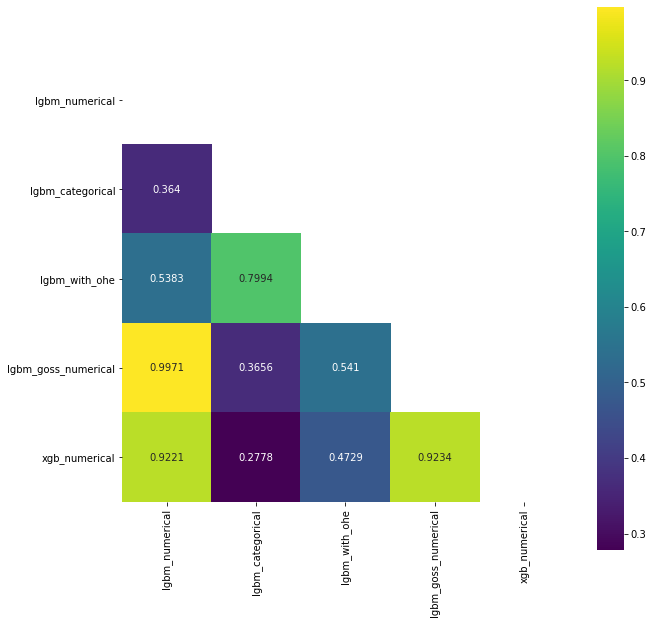

In [104]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

## Среднее

In [105]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

# 0.6*best + 0.4*(best-1)
# scipy.optimize

Score = 0.7191


## GMean

In [106]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7203


## Rankdata

In [38]:
# ROC-AUC / GINI
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7067


In [39]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.6941


In [40]:
!pip install catboost

     |████████████████████████████████| 67.3MB 55kB/s 


In [41]:
import catboost as cb

In [42]:
# for i in castboost_category:
#   data[i] = data[i].astype('object')

In [43]:
data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Kaggle /7/train.csv")

test = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Kaggle /7/test.csv")
print("data.shape = {} rows, {} cols".format(*data.shape))

data.shape = 110093 rows, 3 cols


In [44]:
train = pd.concat([data, test], axis=0).reset_index(drop=True)
# train = pd.get_dummies(train, columns=categorical)

# data_ohe = train.loc[:data.shape[0]-1]
# test_ohe = train.loc[data.shape[0]:]

In [45]:
data = data.merge(client_profile, on='APPLICATION_NUMBER', how='left')

In [46]:
data_catboost = data.copy()

In [47]:
data_catboost = data_catboost.drop(['APPLICATION_NUMBER',	'TARGET'], axis=1)

In [48]:
categorical = data_catboost.dtypes[data.dtypes == "object"].index
numerical = list(set(data_catboost.columns) - set(categorical))
data_catboost[numerical] = data_catboost[numerical].astype(float)
data_catboost[categorical] = data_catboost[categorical].astype('category')

In [52]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
 #   "task_type": "CPU",
    "max_bin": 20,
    "verbose": 1000,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
   
}

In [73]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
  

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    if categorical:
      X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [55]:
estimators_catboost, oof_preds_catboost = catboost_cross_validation(cb_params, data_catboost, target, cv, categorical=categorical)

# estimators_cat, oof_preds_cat = lightgbm_cross_validation(
#     lgbm_params, data, target, cv, categorical=categorical
# )

Sat Apr 17 08:08:58 2021, Cross-Validation, 110093 rows, 24 cols
0:	test: 0.6157434	test1: 0.6216621	best: 0.6216621 (0)	total: 300ms	remaining: 9m 58s
1000:	test: 0.7319835	test1: 0.7324529	best: 0.7325864 (996)	total: 3m 27s	remaining: 3m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.73264643
bestIteration = 1011

Shrink model to first 1012 iterations.
Fold 1, Valid score = 0.73265
0:	test: 0.6051227	test1: 0.6102662	best: 0.6102662 (0)	total: 217ms	remaining: 7m 12s
1000:	test: 0.7338864	test1: 0.7280825	best: 0.7281057 (995)	total: 3m 25s	remaining: 3m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7305291498
bestIteration = 1416

Shrink model to first 1417 iterations.
Fold 2, Valid score = 0.73053
0:	test: 0.6062012	test1: 0.6055698	best: 0.6055698 (0)	total: 231ms	remaining: 7m 40s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7241944569
bestIteration = 893

Shrink model to first 894 iterations.
Fold 3, Vali

CatBoost numerical

In [93]:
categorical

Index(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], dtype='object')

In [59]:
data_catboost.drop(categorical, axis = 1).head(2)

,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1.0,157500.0,855000.0,25128.0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,135000.0,1006920.0,42660.0,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0
3,0.0,180000.0,518562.0,22972.5,0.031329,22338.0,365243.0,NaN,0.0,0.0,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
estimators_catboost, oof_preds_catboost_numeric = catboost_cross_validation(cb_params, data_catboost[numerical], target, cv, categorical=None)

Sat Apr 17 08:41:35 2021, Cross-Validation, 110093 rows, 20 cols
0:	test: 0.5662721	test1: 0.5830915	best: 0.5830915 (0)	total: 87.3ms	remaining: 2m 54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7256090266
bestIteration = 576

Shrink model to first 577 iterations.
Fold 1, Valid score = 0.72561
0:	test: 0.6144648	test1: 0.6171636	best: 0.6171636 (0)	total: 46.2ms	remaining: 1m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7220546853
bestIteration = 893

Shrink model to first 894 iterations.
Fold 2, Valid score = 0.72205
0:	test: 0.6125419	test1: 0.6082685	best: 0.6082685 (0)	total: 51.5ms	remaining: 1m 42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7150164681
bestIteration = 649

Shrink model to first 650 iterations.
Fold 3, Valid score = 0.71502
0:	test: 0.5845799	test1: 0.5693657	best: 0.5693657 (0)	total: 70.6ms	remaining: 2m 21s
1000:	test: 0.7296439	test1: 0.7064474	best: 0.7067609 (971)	total: 1m 25s	rema

Catboost with categorical features

In [69]:
estimators_catboost, oof_preds_catboost_cat = catboost_cross_validation(cb_params, data_catboost[categorical], target, cv, categorical=categorical)

Sat Apr 17 08:38:44 2021, Cross-Validation, 110093 rows, 4 cols


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0:	test: 0.5168666	test1: 0.5173221	best: 0.5173221 (0)	total: 114ms	remaining: 3m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5173221365
bestIteration = 0

Shrink model to first 1 iterations.
Fold 1, Valid score = 0.51732
0:	test: 0.5165237	test1: 0.5193651	best: 0.5193651 (0)	total: 92.3ms	remaining: 3m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.519365137
bestIteration = 0

Shrink model to first 1 iterations.
Fold 2, Valid score = 0.51937
0:	test: 0.5165908	test1: 0.5189079	best: 0.5189079 (0)	total: 85.5ms	remaining: 2m 50s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5189078592
bestIteration = 0

Shrink model to first 1 iterations.
Fold 3, Valid score = 0.51891
0:	test: 0.5164222	test1: 0.5200180	best: 0.5200180 (0)	total: 123ms	remaining: 4m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5200180078
bestIteration = 0

Shrink model to first 1 iterations.
Fold 4, Valid score = 0.520

the worst result


In [75]:
scores = pd.DataFrame({
    "lgbm_numerical": oof_preds,
    "lgbm_categorical": oof_preds_cat,
    "lgbm_with_ohe": oof_preds_with_ohe,
    "lgbm_goss_numerical": oof_preds_goss,
    "xgb_numerical": xgb_oof,
    "catbost_base": oof_preds_catboost,
    "oof_preds_catboost_numeric": oof_preds_catboost_numeric,
    "oof_preds_catboost_cat": oof_preds_catboost_cat
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

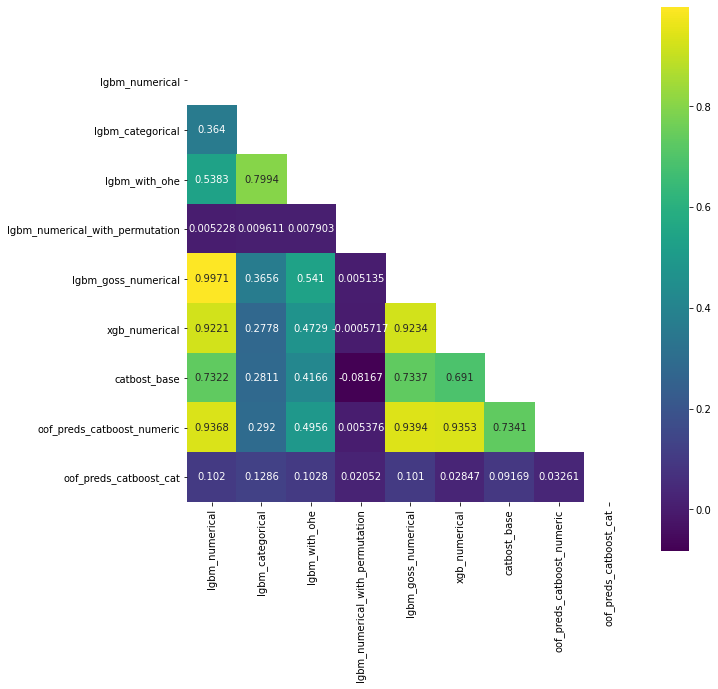

In [76]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

## Среднее

In [78]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

# 0.6*best + 0.4*(best-1)
# scipy.optimize

Score = 0.7187


## GMean

In [79]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7212


## Rankdata

In [80]:
# ROC-AUC / GINI
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7076


In [81]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.6939


## We had
### mean Score = 0.7191
### Gmean Score = 0.7203
### Rankdata = 0.7067

with catboost result has become worse

We can try not to include catboost base result and result with categorical features 

In [107]:
scores = pd.DataFrame({
    "lgbm_numerical": oof_preds,
    "lgbm_categorical": oof_preds_cat,
    "lgbm_with_ohe": oof_preds_with_ohe,
    "lgbm_goss_numerical": oof_preds_goss,
    "xgb_numerical": xgb_oof,
    "oof_preds_catboost_numeric": oof_preds_catboost_numeric
  })

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [108]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

# 0.6*best + 0.4*(best-1)
# scipy.optimize

Score = 0.7203


In [109]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7215


In [110]:
# ROC-AUC / GINI
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7172


# выводы
#### Все модели с цисловыми признаками сильно коррелированы.
#### Луший результат (0.73265) пока получен при использовании catboost со всеми признаками, но думаю, что при работе с гиперпараметрами другие модели тоже покажут неплохие результаты. 